* Compare minimum salinity value, location, fresh water amount between ferry observation, nowcast and new model results.

In [1]:
from __future__ import division, print_function
from salishsea_tools import (nc_tools,viz_tools,stormtools,tidetools)
from salishsea_tools.nowcast import figures
from datetime import datetime, timedelta
from pylab import *
from sklearn import linear_model
from glob import glob
from IPython.core.display import HTML
from salishsea_tools.nowcast import figures
import matplotlib.pyplot as plt
import scipy.io as sio
import netCDF4 as nc
import numpy as np
import math
import os
import datetime
%matplotlib inline

In [2]:
import sys
sys.path.append('/ocean/jieliu/research/meopar/analysis/jie/salinity_comparison/')
import salinity

In [3]:
paths = {'nowcast': '/data/dlatorne/MEOPAR/SalishSea/nowcast/',
        'longerresult': '/ocean/jieliu/research/meopar/river-treatment/14days_norefraserxml/',
        'widenresult': '/data/jieliu/MEOPAR/river-treatment/24nor_NW/' }

In [4]:
run_date = datetime.datetime(2015,6,16)
# Results dataset location
results_home = paths['longerresult']
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [5]:
grid_T_hr = salinity.results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea5.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
#filepath_name = salinity.date(run_date.year,run_date.month, run_date.day,\
                              #run_date.day,run_date.day, paths['longerresult'],'1h','grid_T') 

In [6]:
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']
sal_hr = grid_T_hr.variables['vosaline']
t, z = 3, 1
sal_hr_1 = np.ma.masked_values(sal_hr[t, z], 0)
sal_hr_ave = np.ma.masked_values(np.mean(sal_hr[t, 0:3], axis = 0), 0)

In [7]:
def freshwater_amount(saline, run_date, results_home):
    """This function was to calculate freshwater amount for observation, 1.5m &
        average 3m model nowcasts & new results, we assume salinity below 30 is 
        freshwater"""
    lon11, lat11, lon1_2_4, lat1_2_4,\
    value_mean_3rd_hour, value_mean_4rd_hour, \
    value_mean_ave3rd, value_mean_ave4rd,\
    salinity11, salinity1_2_4,date_str = salinity.salinity_fxn(saline, run_date, results_home)
    
    salinity1_2_4[np.isnan(salinity1_2_4)] = 30 ##set nan to 30 psu for observation
    
    obs_Sdx = np.zeros(len(lon1_2_4)-1) ## index from 0 to 718
    mod_now_15Sdx = np.zeros(len(lon11)-1)
    mod_new_15Sdx = np.zeros(len(lon11)-1)
    mod_now_aveSdx = np.zeros(len(lon11)-1)
    mod_new_aveSdx = np.zeros(len(lon11)-1)

    length_obs = np.arange(len(lon1_2_4)-1)
    length_mod = np.arange(len(lon11) - 1)
    ## For observation:
    for i in length_obs:
        obs_Sdx[i] = (30 - salinity1_2_4[:,0][i]) * -np.diff(lon1_2_4[:,0])[i] * \
        111000 * cos(pi*lat1_2_4[i]/180) #discrete outcome by multiplying 
    obs_total_integral = np.cumsum(obs_Sdx)
    max_amount_obs = max(obs_total_integral)
    if max_amount_obs <= 0:
        max_amount_obs == -min(obs_total_integral)
    ## For nowcasts results:    
    if results_home == paths['nowcast']:    #fresh water salinity(diff between 28 and salinity) and dx
        for j in length_mod:
            mod_now_15Sdx[j] = (30 - value_mean_3rd_hour[:,0][j]) * -np.diff(lon11[:,0])[j] * \
            111000 * cos(pi*lat11[j]/180)  ## whether np.diff is positive or not depends
                                      # on the ferry route
            mod_now_aveSdx[j] = (30 - value_mean_ave3rd[:,0][j]) * -np.diff(lon11[:,0])[j] * \
            111000 * cos(pi*lat11[j]/180) 
        mod_total_now_15integral = np.cumsum(mod_now_15Sdx)
        mod_total_now_aveintegral = np.cumsum(mod_now_aveSdx)  
        ## Find max for 1.5m & average 3m depth nowcast result
        max_mod_now15 = max(mod_total_now_15integral)
        max_mod_nowave = max(mod_total_now_aveintegral)
    
        if max_mod_now15 <= 0:
            max_mod_now15 == -min(mod_total_now_15integral)
        if max_mod_nowave <=0:
            max_mod_nowave == -min(mod_total_now_aveintegral)
        
        return max_amount_obs, max_mod_now15, max_mod_nowave
   
    if results_home == paths['longerresult']:
        for j in length_mod:
            mod_new_15Sdx[j] = (30 - value_mean_3rd_hour[:,0][j]) * -np.diff(lon11[:,0])[j] * \
            111000 * cos(pi*lat11[j]/180)
            mod_new_aveSdx[j] = (30 - value_mean_ave3rd[:,0][j]) * -np.diff(lon11[:,0])[j] * \
            111000 * cos(pi*lat11[j]/180)
        mod_total_new_15integral = np.cumsum(mod_new_15Sdx)
        mod_total_new_aveintegral = np.cumsum(mod_new_aveSdx)
        ## Find max for 1.5m & average 3m depth new result
        max_mod_new15 = max(mod_total_new_15integral)
        max_mod_newave = max(mod_total_new_aveintegral)
        
        if max_mod_new15 <=0:
            max_mod_new15 == -min(mod_total_new_15integral)
        if max_mod_newave <=0:
            max_mod_newave == -min(mod_total_new_aveintegral)
        return max_amount_obs, max_mod_new15, max_mod_newave

# salinity data on June 16

In [8]:
## minimum salinity for observation and nowcast
run_date = datetime.datetime(2015,6,16)
results_home = paths['nowcast']
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150615.mat')
salinity16_min_obs, lon16_min_obs, salinity16_min_15,\
lon16_min_15, salinity16_min_ave, lon16_min_ave = salinity.find_min_value_location(run_date,results_home, saline)

In [10]:
##  freshwater amount for observation and nowcast
max16_amount_obs, max16_now_15, max16_now_ave = freshwater_amount(saline, run_date,results_home)

In [14]:
## minimim salinity for observation and new model result
results_home = paths['longerresult']
salinity16_min_obs, lon16_min_obs, salinity16_min_15_new,\
lon16_min_15_new, salinity16_min_ave_new, lon16_min_ave_new \
= salinity.find_min_value_location(run_date,results_home, saline)

In [15]:
##  freshwater amount for observation and new result
max16_amount_obs, max16_new_15, max16_new_ave = freshwater_amount(saline, run_date,results_home)

# salinity data on June 17

In [16]:
## minimum salinity for observation and nowcast
run_date = datetime.datetime(2015,6,17)
results_home = paths['nowcast']
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150616.mat')
salinity17_min_obs, lon17_min_obs, salinity17_min_15,\
lon17_min_15, salinity17_min_ave, lon17_min_ave = salinity.find_min_value_location(run_date,results_home, saline)

In [17]:
##  freshwater amount for observation and nowcast
max17_amount_obs, max17_now_15, max17_now_ave = freshwater_amount(saline, run_date,results_home)

In [18]:
## minimim salinity for observation and new model result
results_home = paths['longerresult']
salinity17_min_obs, lon17_min_obs, salinity17_min_15_new,\
lon17_min_15_new, salinity17_min_ave_new, lon17_min_ave_new \
= salinity.find_min_value_location(run_date,results_home, saline)

In [19]:
##  freshwater amount for observation and new result
max17_amount_obs, max17_new_15, max17_new_ave = freshwater_amount(saline, run_date,results_home)

# salinity data on June 18

In [20]:
## minimum salinity for observation and nowcast
run_date = datetime.datetime(2015,6,18)
results_home = paths['nowcast']
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150617.mat')
salinity16_min_obs, lon18_min_obs, salinity18_min_15,\
lon18_min_15, salinity18_min_ave, lon18_min_ave = salinity.find_min_value_location(run_date,results_home, saline)

In [21]:
##  freshwater amount for observation and nowcast
max18_amount_obs, max18_now_15, max18_now_ave = freshwater_amount(saline, run_date,results_home)

In [22]:
## minimim salinity for observation and new model result
results_home = paths['longerresult']
salinity18_min_obs, lon18_min_obs, salinity18_min_15_new,\
lon18_min_15_new, salinity18_min_ave_new, lon18_min_ave_new \
= salinity.find_min_value_location(run_date,results_home, saline)

In [23]:
##  freshwater amount for observation and new result
max18_amount_obs, max18_new_15, max18_new_ave = freshwater_amount(saline, run_date,results_home)

* ferry data from June 19 to 21 are not usable

# salinity data on June 22

In [25]:
## minimum salinity for observation and nowcast
run_date = datetime.datetime(2015,6,22)
results_home = paths['nowcast']
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150621.mat')
salinity22_min_obs, lon22_min_obs, salinity22_min_15,\
lon22_min_15, salinity22_min_ave, lon22_min_ave = salinity.find_min_value_location(run_date,results_home, saline)

In [26]:
##  freshwater amount for observation and nowcast
max22_amount_obs, max22_now_15, max22_now_ave = freshwater_amount(saline, run_date,results_home)

In [27]:
## minimim salinity for observation and new model result
results_home = paths['longerresult']
salinity22_min_obs, lon22_min_obs, salinity22_min_15_new,\
lon22_min_15_new, salinity22_min_ave_new, lon22_min_ave_new \
= salinity.find_min_value_location(run_date,results_home, saline)

In [28]:
##  freshwater amount for observation and new result
max22_amount_obs, max22_new_15, max22_new_ave = freshwater_amount(saline, run_date,results_home)

# salinity data on June 23

In [29]:
## minimum salinity for observation and nowcast
run_date = datetime.datetime(2015,6,23)
results_home = paths['nowcast']
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150622.mat')
salinity23_min_obs, lon23_min_obs, salinity23_min_15,\
lon23_min_15, salinity23_min_ave, lon23_min_ave = salinity.find_min_value_location(run_date,results_home, saline)

In [30]:
##  freshwater amount for observation and nowcast
max23_amount_obs, max23_now_15, max23_now_ave = freshwater_amount(saline, run_date,results_home)

In [31]:
## minimim salinity for observation and new model result
results_home = paths['longerresult']
salinity23_min_obs, lon23_min_obs, salinity23_min_15_new,\
lon23_min_15_new, salinity23_min_ave_new, lon23_min_ave_new \
= salinity.find_min_value_location(run_date,results_home, saline)

In [32]:
##  freshwater amount for observation and new result
max23_amount_obs, max23_new_15, max23_new_ave = freshwater_amount(saline, run_date,results_home)

# salinity data on June 24

In [33]:
## minimum for observation and nowcast
run_date = datetime.datetime(2015,6,24)
results_home = paths['nowcast']
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150623.mat')
salinity24_min_obs, lon24_min_obs, salinity24_min_15,\
lon24_min_15, salinity24_min_ave, lon24_min_ave = salinity.find_min_value_location(run_date,results_home, saline)

In [34]:
##  freshwater amount for observation and nowcast
max24_amount_obs, max24_now_15, max24_now_ave = freshwater_amount(saline, run_date,results_home)

In [35]:
## minimum for observation and new model result
results_home = paths['longerresult']
salinity24_min_obs, lon24_min_obs, salinity24_min_15_new,\
lon24_min_15_new, salinity24_min_ave_new, lon24_min_ave_new \
= salinity.find_min_value_location(run_date,results_home, saline)

In [36]:
##  freshwater amount for observation and new result
max24_amount_obs, max24_new_15, max24_new_ave = freshwater_amount(saline, run_date,results_home)

# salinity data on June 25

In [37]:
## minimum for observation and nowcast
run_date = datetime.datetime(2015,6,25)
results_home = paths['nowcast']
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150624.mat')
salinity25_min_obs, lon25_min_obs, salinity25_min_15,\
lon25_min_15, salinity25_min_ave, lon25_min_ave = salinity.find_min_value_location(run_date,results_home, saline)

In [38]:
##  freshwater amount for observation and nowcast
max25_amount_obs, max25_now_15, max25_now_ave = freshwater_amount(saline, run_date,results_home)

In [39]:
## minimum for observation and new model result
results_home = paths['longerresult']
salinity25_min_obs, lon25_min_obs, salinity25_min_15_new,\
lon25_min_15_new, salinity25_min_ave_new, lon25_min_ave_new \
= salinity.find_min_value_location(run_date,results_home, saline)

In [40]:
##  freshwater amount for observation and new result
max25_amount_obs, max25_new_15, max25_new_ave = freshwater_amount(saline, run_date,results_home)

# salinity data on June 26

In [41]:
## minimum for observation and nowcast
run_date = datetime.datetime(2015,6,26)
results_home = paths['nowcast']
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150625.mat')
salinity26_min_obs, lon26_min_obs, salinity26_min_15,\
lon26_min_15, salinity26_min_ave, lon26_min_ave = salinity.find_min_value_location(run_date,results_home, saline)

In [42]:
##  freshwater amount for observation and nowcast
max26_amount_obs, max26_now_15, max26_now_ave = freshwater_amount(saline, run_date,results_home)

In [43]:
## minimum for observation and new model result
results_home = paths['longerresult']
salinity26_min_obs, lon26_min_obs, salinity26_min_15_new,\
lon26_min_15_new, salinity26_min_ave_new, lon26_min_ave_new \
= salinity.find_min_value_location(run_date,results_home, saline)

In [44]:
##  freshwater amount for observation and new result
max26_amount_obs, max26_new_15, max26_new_ave = freshwater_amount(saline, run_date,results_home)

# salinity data on June 27

In [45]:
## minimum for observation and nowcast
run_date = datetime.datetime(2015,6,27)
results_home = paths['nowcast']
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150626.mat')
salinity27_min_obs, lon27_min_obs, salinity27_min_15,\
lon27_min_15, salinity27_min_ave, lon27_min_ave = salinity.find_min_value_location(run_date,results_home, saline)

In [46]:
##  freshwater amount for observation and nowcast
max27_amount_obs, max27_now_15, max27_now_ave = freshwater_amount(saline, run_date,results_home)

In [47]:
## minimum for observation and new model result
results_home = paths['longerresult']
salinity27_min_obs, lon27_min_obs, salinity27_min_15_new,\
lon27_min_15_new, salinity27_min_ave_new, lon27_min_ave_new \
= salinity.find_min_value_location(run_date,results_home, saline)

In [48]:
##  freshwater amount for observation and new result
max27_amount_obs, max27_new_15, max27_new_ave = freshwater_amount(saline, run_date,results_home)

# salinity data on June 28

In [49]:
## minimum for observation and nowcast
run_date = datetime.datetime(2015,6,28)
results_home = paths['nowcast']
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150627.mat')
salinity28_min_obs, lon28_min_obs, salinity28_min_15,\
lon28_min_15, salinity28_min_ave, lon28_min_ave = salinity.find_min_value_location(run_date,results_home, saline)

In [50]:
##  freshwater amount for observation and nowcast
max28_amount_obs, max28_now_15, max28_now_ave = freshwater_amount(saline, run_date,results_home)

In [51]:
## minimum for observation and new model result
results_home = paths['longerresult']
salinity28_min_obs, lon28_min_obs, salinity28_min_15_new,\
lon28_min_15_new, salinity28_min_ave_new, lon28_min_ave_new \
= salinity.find_min_value_location(run_date,results_home, saline)

In [52]:
##  freshwater amount for observation and new result
max28_amount_obs, max28_new_15, max28_new_ave = freshwater_amount(saline, run_date,results_home)

# salinity data on June 29

In [53]:
## minimum for observation and nowcast
run_date = datetime.datetime(2015,6,29)
results_home = paths['nowcast']
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150628.mat')
salinity29_min_obs, lon29_min_obs, salinity29_min_15,\
lon29_min_15, salinity29_min_ave, lon29_min_ave = salinity.find_min_value_location(run_date,results_home, saline)

In [54]:
##  freshwater amount for observation and nowcast
max29_amount_obs, max29_now_15, max29_now_ave = freshwater_amount(saline, run_date,results_home)

In [55]:
## minimum for observation and new model result
results_home = paths['longerresult']
salinity29_min_obs, lon29_min_obs, salinity29_min_15_new,\
lon29_min_15_new, salinity29_min_ave_new, lon29_min_ave_new \
= salinity.find_min_value_location(run_date,results_home, saline)

In [56]:
##  freshwater amount for observation and new result
max29_amount_obs, max29_new_15, max29_new_ave = freshwater_amount(saline, run_date,results_home)

* combine daily minimum salinity value and location to a time sery

In [57]:
## for observation
min_obs_value = [salinity16_min_obs, salinity17_min_obs, salinity18_min_obs,\
                salinity22_min_obs,salinity23_min_obs,salinity24_min_obs,\
                salinity25_min_obs,salinity26_min_obs,salinity27_min_obs,\
                salinity28_min_obs,salinity28_min_obs]

min_obs_lon = [lon16_min_obs, lon17_min_obs, lon18_min_obs, lon22_min_obs,\
              lon23_min_obs, lon24_min_obs, lon25_min_obs, lon26_min_obs,\
              lon27_min_obs, lon28_min_obs, lon29_min_obs]

In [58]:
## for nowcast 1.5m & average 3m result
min_now15_value = [salinity16_min_15, salinity17_min_15, salinity18_min_15,\
                  salinity22_min_15, salinity23_min_15, salinity24_min_15,\
                  salinity25_min_15, salinity26_min_15, salinity27_min_15,\
                  salinity28_min_15, salinity29_min_15]

min_now15_lon = [lon16_min_15, lon17_min_15, lon18_min_15, lon22_min_15,\
                lon23_min_15,lon24_min_15,lon25_min_15, lon26_min_15,\
                lon27_min_15, lon28_min_15, lon29_min_15]

min_nowave_value = [salinity16_min_ave, salinity17_min_ave, salinity18_min_ave,\
                    salinity22_min_ave, salinity23_min_ave, salinity24_min_ave,\
                    salinity25_min_ave, salinity26_min_ave, salinity27_min_ave,\
                    salinity28_min_ave, salinity29_min_ave]

min_nowave_lon = [lon16_min_ave, lon17_min_ave, lon18_min_ave,\
                    lon22_min_ave, lon23_min_ave, lon24_min_ave,\
                    lon25_min_ave, lon26_min_ave, lon27_min_ave,\
                    lon28_min_ave, lon29_min_ave]

In [59]:
## for new result with 1.5m & average 3m result
min_new15_value = [salinity16_min_15_new, salinity17_min_15_new, salinity18_min_15_new,\
                   salinity22_min_15_new, salinity23_min_15_new, salinity24_min_15_new,\
                   salinity25_min_15_new, salinity26_min_15_new, salinity27_min_15_new,\
                   salinity28_min_15_new, salinity29_min_15_new]

min_new15_lon = [lon16_min_15_new, lon17_min_15_new, lon18_min_15_new,\
                   lon22_min_15_new, lon23_min_15_new, lon24_min_15_new,\
                   lon25_min_15_new, lon26_min_15_new, lon27_min_15_new,\
                   lon28_min_15_new, lon29_min_15_new]

min_newave_value = [salinity16_min_ave_new, salinity17_min_ave_new, salinity18_min_ave_new,\
                    salinity22_min_ave_new, salinity23_min_ave_new, salinity24_min_ave_new,\
                    salinity25_min_ave_new, salinity26_min_ave_new, salinity27_min_ave_new,\
                    salinity28_min_ave_new, salinity29_min_ave_new]

min_newave_lon = [lon16_min_ave_new, lon17_min_ave_new, lon18_min_ave_new,\
                    lon22_min_ave_new, lon23_min_ave_new, lon24_min_ave_new,\
                    lon25_min_ave_new, lon26_min_ave_new, lon27_min_ave_new,\
                    lon28_min_ave_new, lon29_min_ave_new]

* combine fresh water amount for observation, nowcasts and new results

In [60]:
obs_amount = [max16_amount_obs, max17_amount_obs, max18_amount_obs,\
             max22_amount_obs, max23_amount_obs, max24_amount_obs,\
             max25_amount_obs, max26_amount_obs, max27_amount_obs,\
             max28_amount_obs,max29_amount_obs]

In [61]:
## for 1.5m nowcasts and average 3m nowcasts
mod15_now_amount = [max16_now_15, max17_now_15, max18_now_15,\
                   max22_now_15, max23_now_15, max24_now_15,\
                   max25_now_15, max26_now_15, max27_now_15,\
                   max28_now_15, max29_now_15]

modave_now_amount = [max16_now_ave, max17_now_ave, max18_now_ave,\
                    max22_now_ave, max23_now_ave, max24_now_ave,\
                    max25_now_ave, max26_now_ave, max27_now_ave,\
                    max28_now_ave, max29_now_ave]

In [62]:
## for 1.5m and average 3m new results
mod15_new_amount = [max16_new_15, max17_new_15, max18_new_15,\
                   max22_new_15, max23_new_15, max24_new_15,\
                   max25_new_15, max26_new_15, max27_new_15,\
                   max28_new_15, max29_new_15]

modave_new_amount = [max16_new_ave, max17_new_ave, max18_new_ave,\
                    max22_new_ave, max23_new_ave, max24_new_ave,\
                    max25_new_ave, max26_new_ave, max27_new_ave,\
                    max28_new_ave, max29_new_ave]


In [63]:
## for time defination 
time =[]
for t in np.arange(11):
    time.append(t)

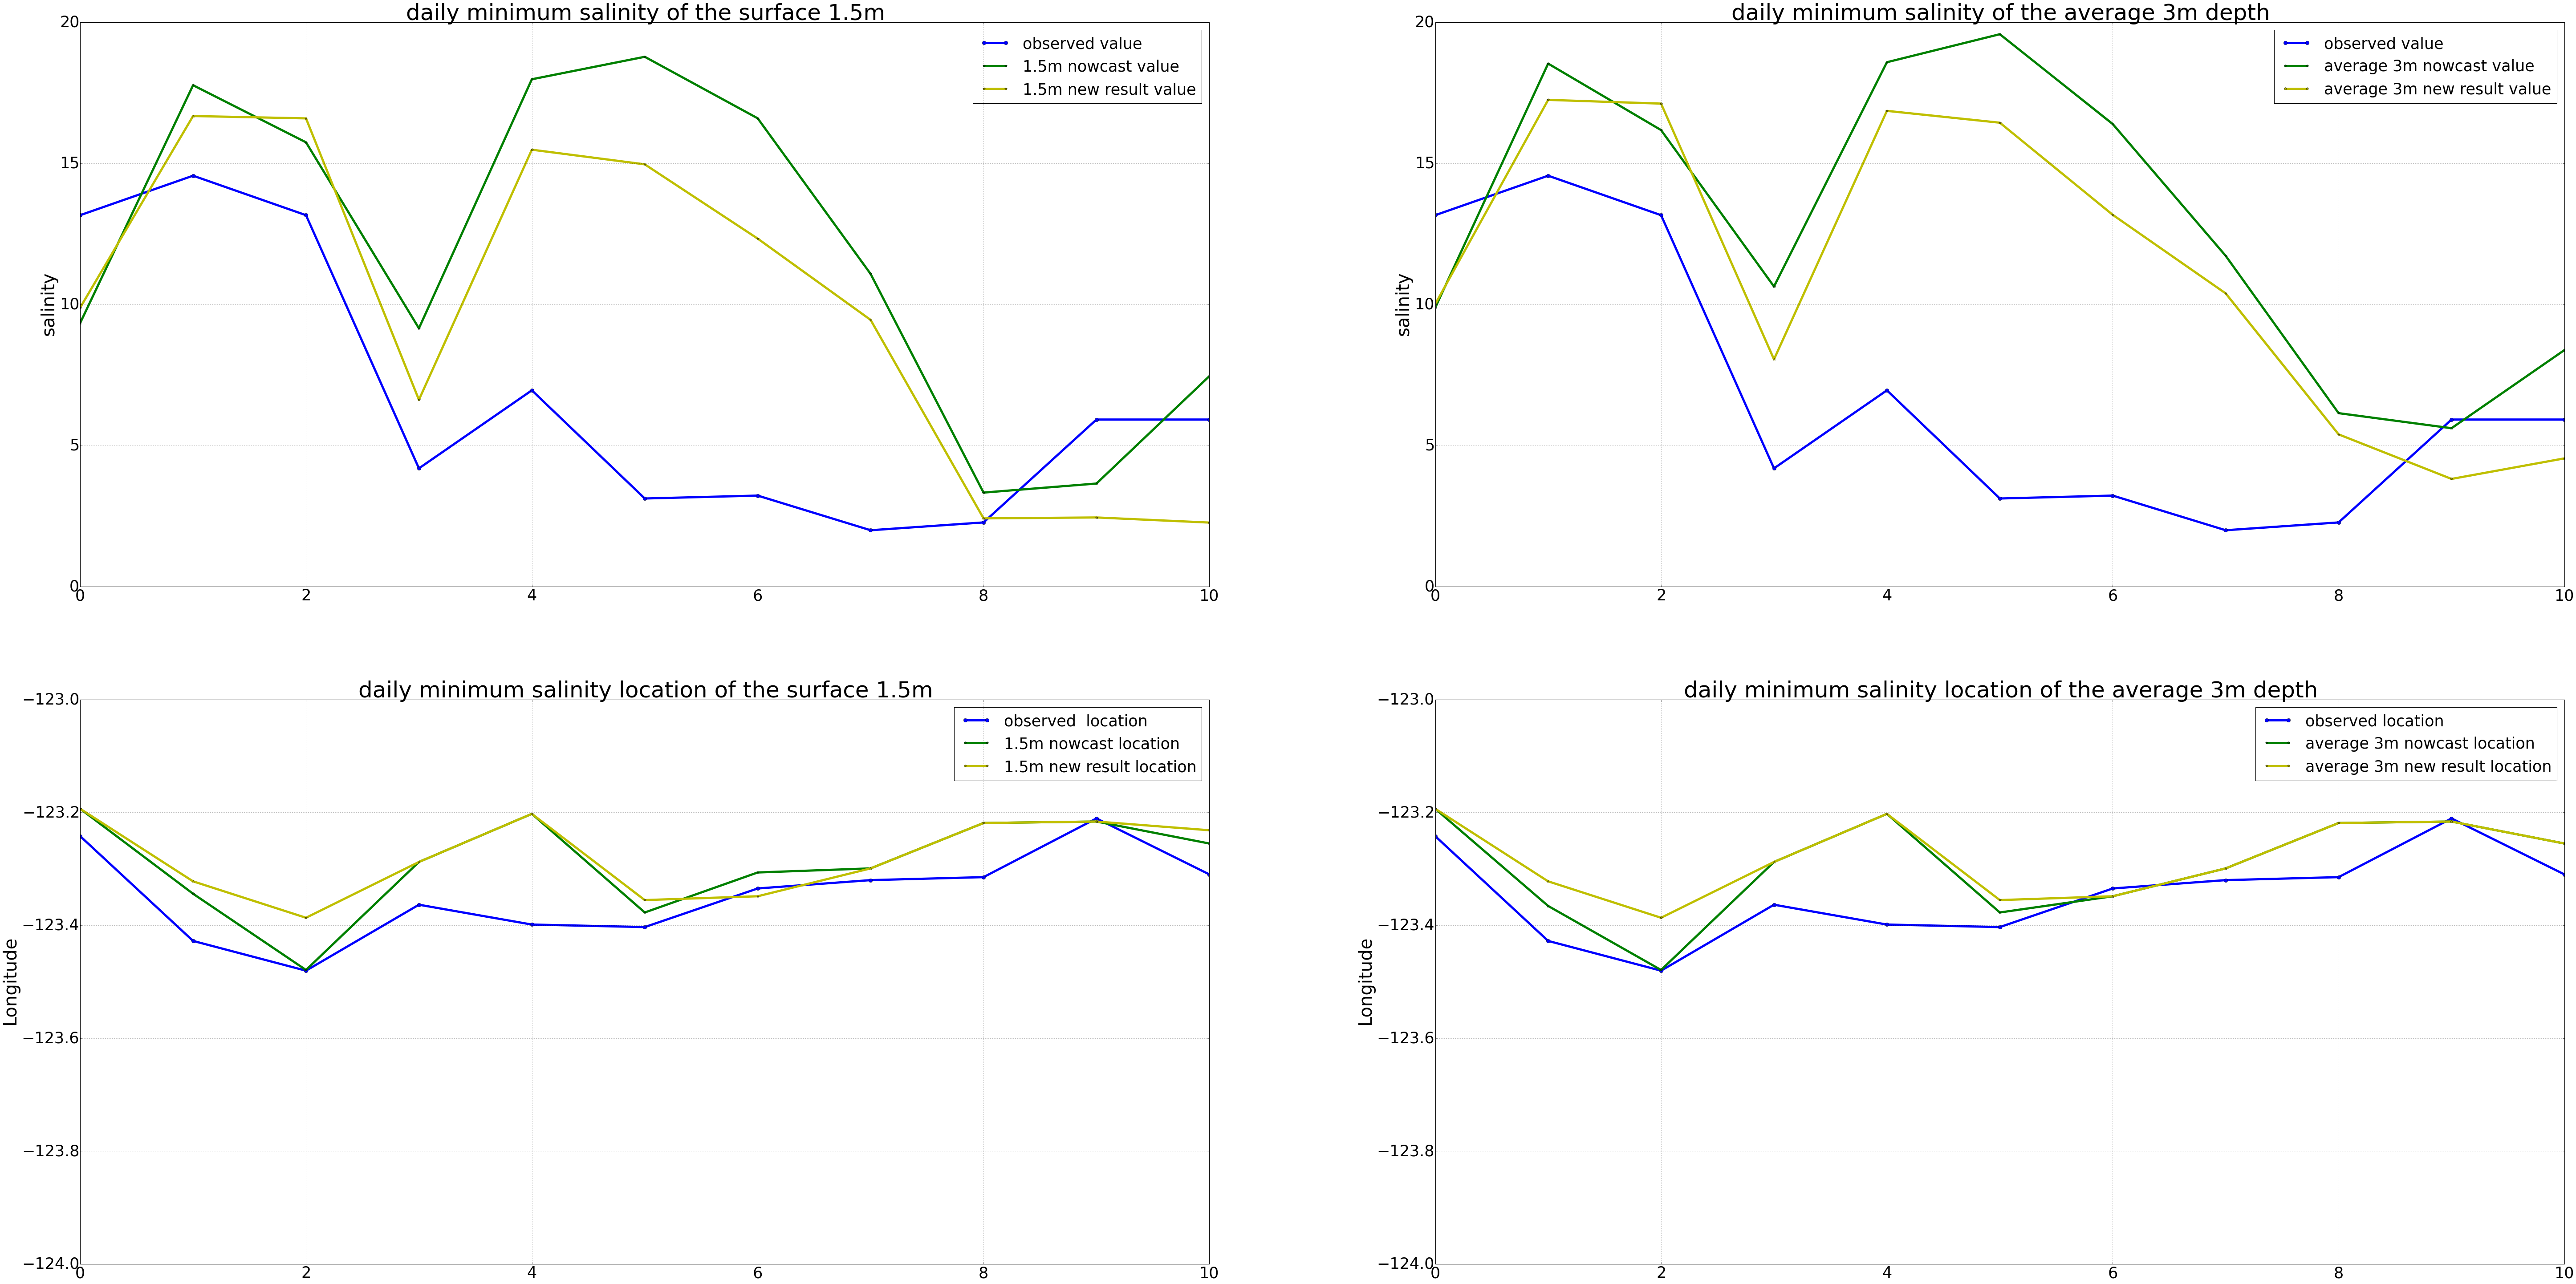

In [64]:
fig, axs = plt.subplots(2, 2, figsize=(100, 50))

## observation & 1.5m nowcast & new model result minimim values
ax = axs[0,0]
ax.plot(time, min_obs_value,'b-', marker = 'o', markersize = 8,linewidth=5.0, label = 'observed value')
ax.plot(time, min_now15_value,'g*-', linewidth=5.0, label = '1.5m nowcast value')
ax.plot(time, min_new15_value,'y*-', linewidth=5.0, label = '1.5m new result value')
plt.setp(ax.get_xticklabels(), fontsize=35)
plt.setp(ax.get_yticklabels(), fontsize=35)
ax.set_title('daily minimum salinity of the surface 1.5m ', fontsize = 50)
#ax.set_xlim(0, 10)
ax.set_ylim(0, 20)
ax.set_ylabel('salinity', fontsize = 40)
ax.grid('on')
ax.legend(fontsize = 35)

## observation & average 3m nowcast & new model result minimim values
ax = axs[0,1]
ax.plot(time, min_obs_value,'bo-', marker = 'o', markersize = 8,linewidth=5.0,label = 'observed value')
ax.plot(time, min_nowave_value,'g*-', linewidth=5.0,label = 'average 3m nowcast value')
ax.plot(time, min_newave_value,'y*-', linewidth=5.0,label = 'average 3m new result value')
plt.setp(ax.get_xticklabels(), fontsize=35)
plt.setp(ax.get_yticklabels(), fontsize=35)
ax.set_title('daily minimum salinity of the average 3m depth ', fontsize = 50)
ax.set_ylabel('salinity', fontsize = 40)
ax.grid('on')
ax.legend(fontsize = 35)

## observation & average 1.5m nowcast & new model result minimim values' lon
ax = axs[1,0]
ax.plot(time, min_obs_lon,'bo-',marker = 'o', markersize = 8,linewidth=5.0, label = 'observed  location')
ax.plot(time, min_now15_lon,'g*-', linewidth=5.0,label = '1.5m nowcast location')
ax.plot(time, min_new15_lon,'y*-', linewidth=5.0,label = '1.5m new result location')
plt.setp(ax.get_xticklabels(), fontsize=35)
plt.setp(ax.get_yticklabels(), fontsize=35)
ax.set_title('daily minimum salinity location of the surface 1.5m ', fontsize = 50)
#ax.set_xlim(0, 10)
ax.set_ylim(-124., -123.)
ax.set_ylabel('Longitude', fontsize = 40)
ax.grid('on')
ax.legend(fontsize = 35)

## observation & average 3m nowcast & new model result minimim values' lon
ax = axs[1,1]
ax.plot(time, min_obs_lon,'bo-', marker = 'o', markersize = 8,linewidth=5.0, label = 'observed location')
ax.plot(time, min_nowave_lon,'g*-',linewidth=5.0, label = 'average 3m nowcast location')
ax.plot(time, min_newave_lon,'y*-', linewidth=5.0,label = 'average 3m new result location')
plt.setp(ax.get_xticklabels(), fontsize=35)
plt.setp(ax.get_yticklabels(), fontsize=35)
ax.set_title('daily minimum salinity location of the average 3m depth ', fontsize = 50)
ax.set_ylim(-124., -123.)
ax.set_ylabel('Longitude', fontsize = 40)
ax.grid('on') ## why no grid on??
ax.legend(fontsize = 35)

# Freshwater amount

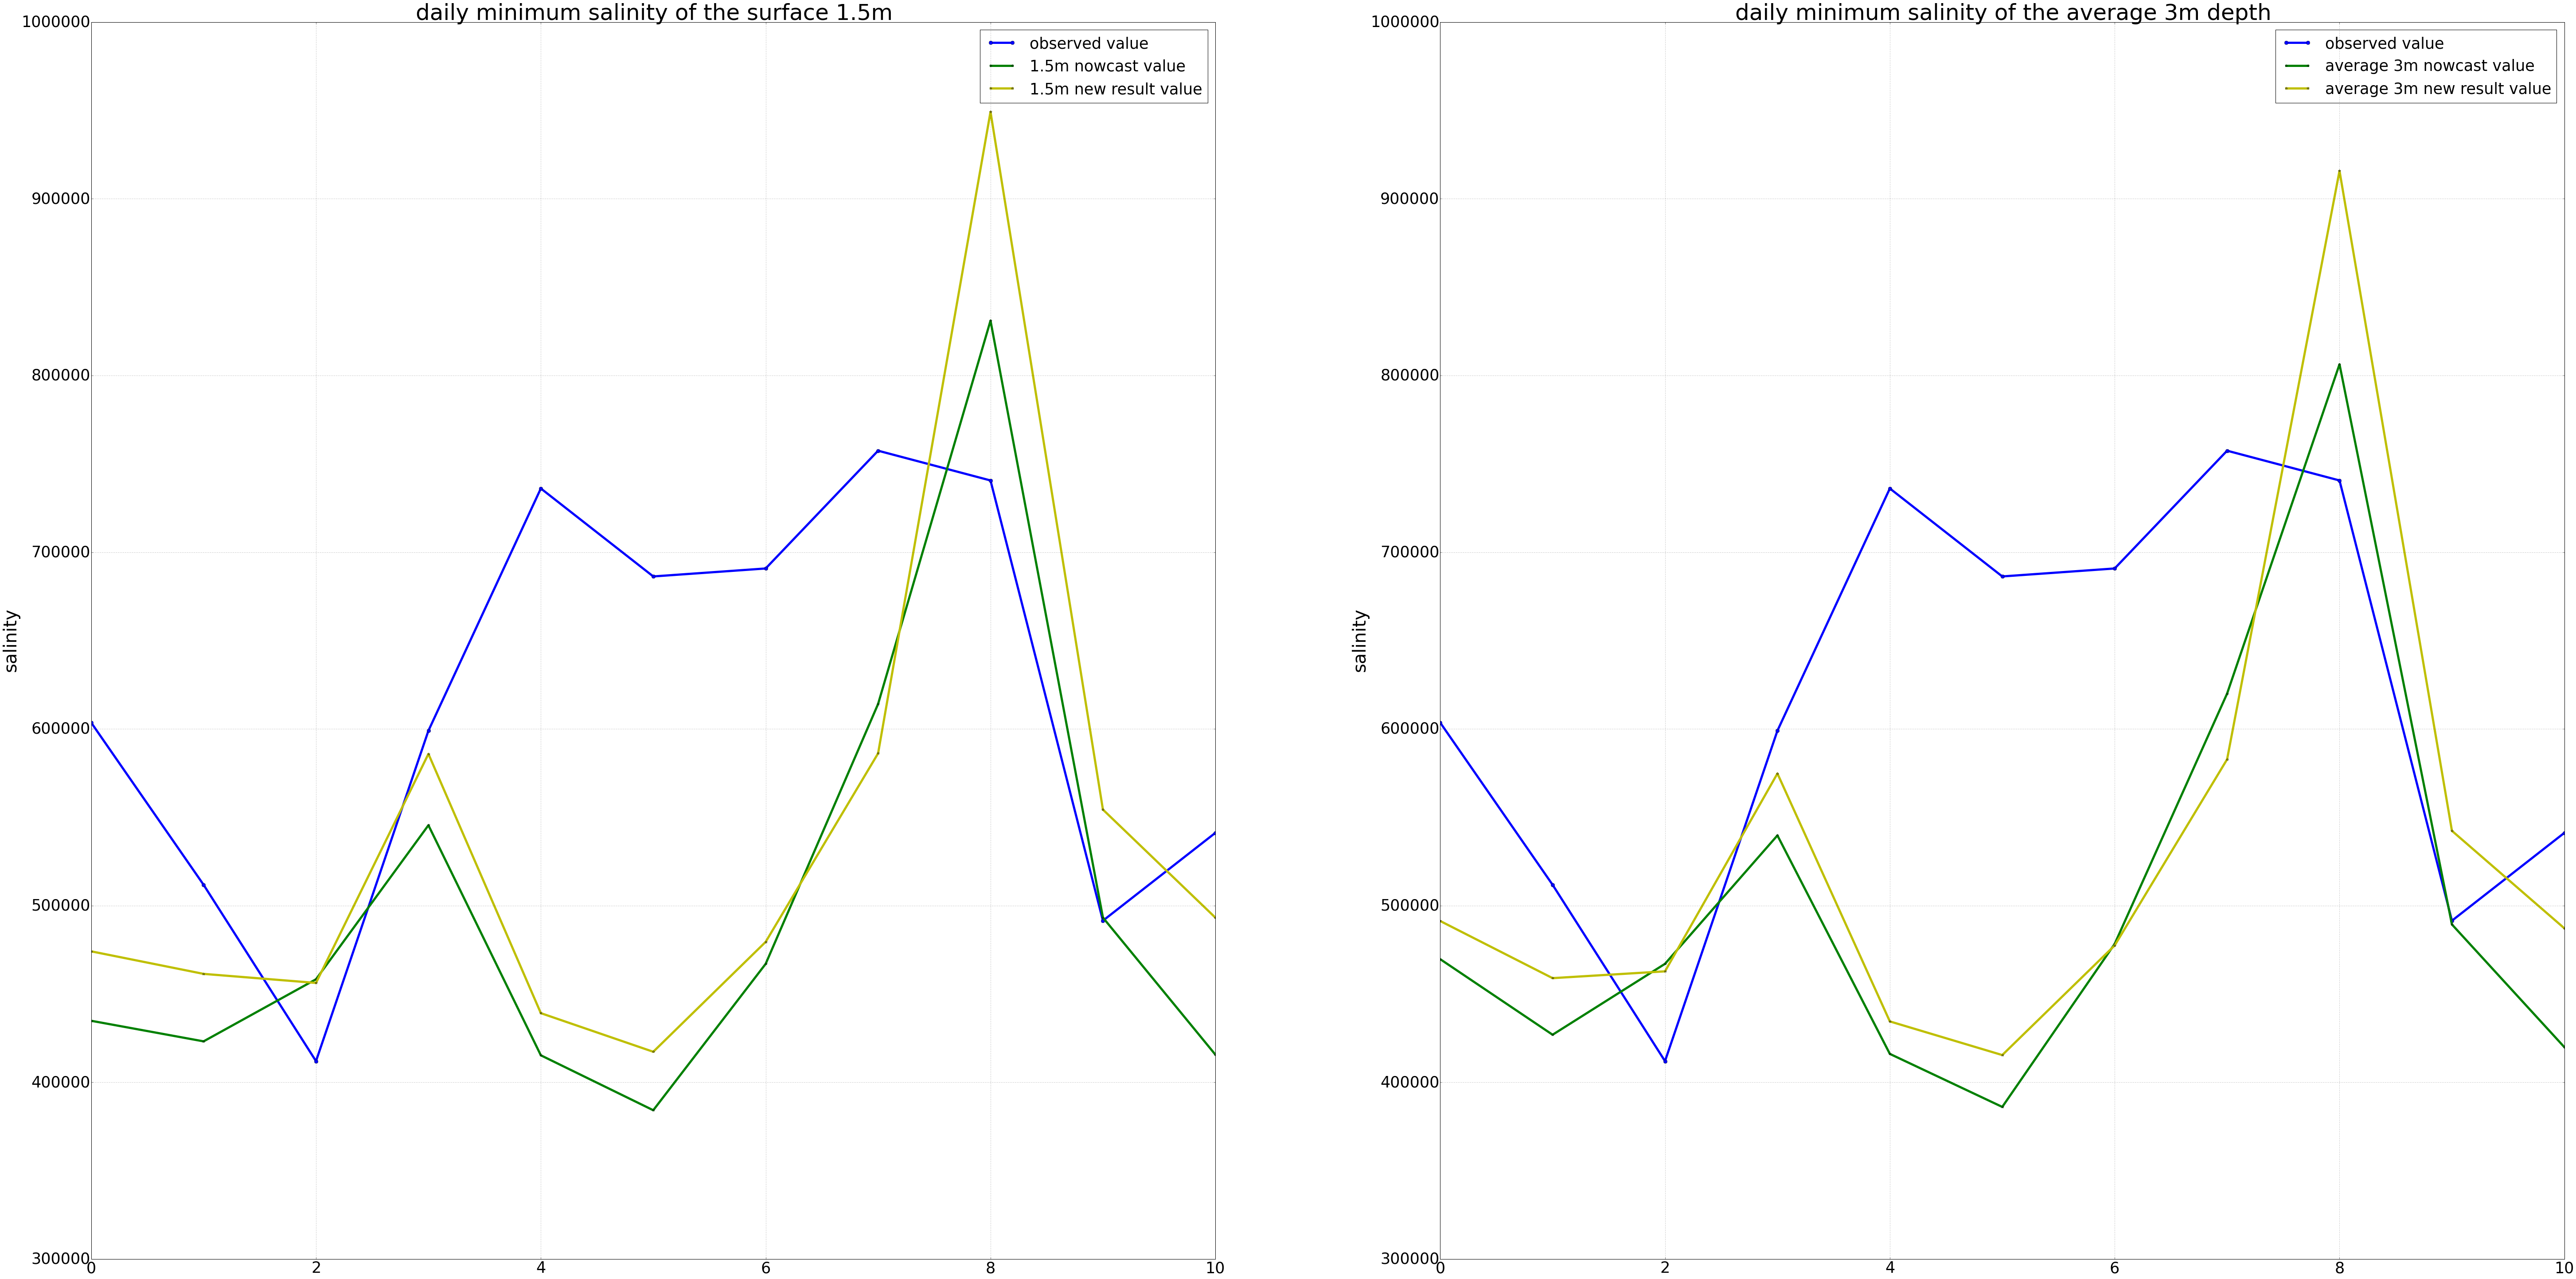

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(100, 50))

## observation & 1.5m nowcast & new model result minimim values
ax = axs[0]
ax.plot(time, obs_amount,'b-', marker = 'o', markersize = 8,linewidth=5.0, label = 'observed value')
ax.plot(time, mod15_now_amount,'g*-', linewidth=5.0, label = '1.5m nowcast value')
ax.plot(time, mod15_new_amount,'y*-', linewidth=5.0, label = '1.5m new result value')
plt.setp(ax.get_xticklabels(), fontsize=35)
plt.setp(ax.get_yticklabels(), fontsize=35)
ax.set_title('daily minimum salinity of the surface 1.5m ', fontsize = 50)
#ax.set_xlim(0, 10)
#ax.set_ylim(0, 20)
ax.set_ylabel('salinity', fontsize = 40)
ax.grid('on')
ax.legend(fontsize = 35)

## observation & average 3m nowcast & new model result minimim values
ax = axs[1]
ax.plot(time, obs_amount,'bo-', marker = 'o', markersize = 8,linewidth=5.0,label = 'observed value')
ax.plot(time, modave_now_amount,'g*-', linewidth=5.0,label = 'average 3m nowcast value')
ax.plot(time, modave_new_amount,'y*-', linewidth=5.0,label = 'average 3m new result value')
plt.setp(ax.get_xticklabels(), fontsize=35)
plt.setp(ax.get_yticklabels(), fontsize=35)
ax.set_title('daily minimum salinity of the average 3m depth ', fontsize = 50)
ax.set_ylabel('salinity', fontsize = 40)
ax.grid('on')
ax.legend(fontsize = 35)
